In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md


This is a 125 microsecond trajectory of fast folding variant of the Villin Headpiece generated from DEShaw Research:

https://www.science.org/doi/full/10.1126/science.1208351

It can be compared to an X-ray structure:
https://www.rcsb.org/structure/2F4K
(Note that the x-ray structure has multiple positions for some sidechain atoms)

You can download the required files here:
https://www.dropbox.com/s/60jxmiuvlyehbhz/Villin_Lab.zip?dl=0

In [2]:
pdb='/Users/hainn/tolu/git/CHEM101.6_S24/exercise3Villin_Lab/2F4K.protein.pdb'
trajectory='/Users/hainn/tolu/git/CHEM101.6_S24/exercise3Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='/Users/hainn/tolu/git/CHEM101.6_S24/exercise3Villin_Lab/2f4K.xray.CA.pdb'
outdir='/Users/hainn/tolu/git/CHEM101.6_S24/exercise3Villin_Lab/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)



outdir: /Users/hainn/tolu/git/CHEM101.6_S24/exercise3Villin_Lab/output
pdb: /Users/hainn/tolu/git/CHEM101.6_S24/exercise3Villin_Lab/2F4K.protein.pdb
trjaectory: /Users/hainn/tolu/git/CHEM101.6_S24/exercise3Villin_Lab/2F4K.protein.s10.dcd


In [3]:
stride_sel=10
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 6280

Starting frame: 0

Last frame: 6280

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA

In [5]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)


In [6]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
trjBB = md.load(trajectory, top=pdb,stride=stride_sel)
BB=top.select("backbone")
trjBB.restrict_atoms(BB)
trjBB.center_coordinates()

dssp=md.compute_dssp(trjBB,simplified=True)


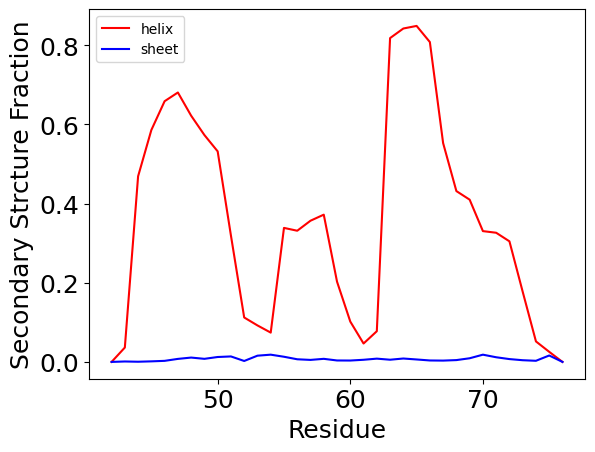

In [8]:
#dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(resid_xray,Hprop,c='r',label='helix')
plt.plot(resid_xray,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [9]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [10]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [11]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




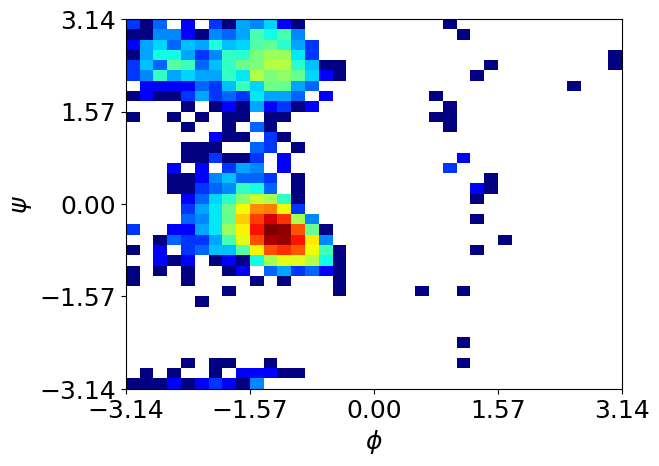

In [12]:
plot_phipsi(45)


In [13]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi_frames(res,frames):
 plt.hist2d(dihedral_dict['phi'][res][frames],dihedral_dict['psi'][res][frames],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi_frames(res,frames):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res][frames],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res][frames],dihedral_dict['chi2'][res][frames],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return

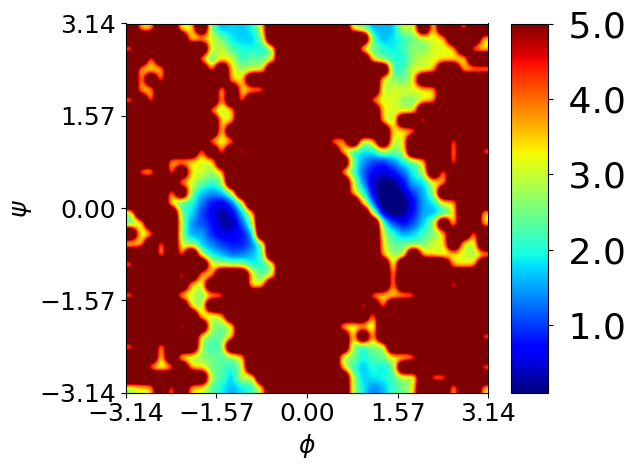

In [14]:
def plot_phipsi_FES(res):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res],dihedral_dict['phi'][res],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return

plot_phipsi_FES(52)

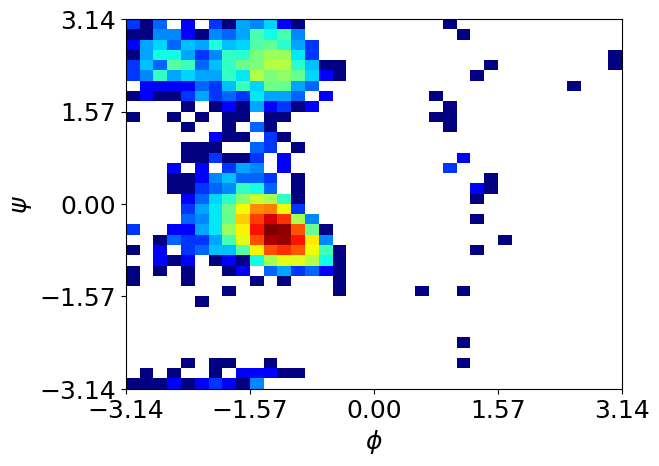

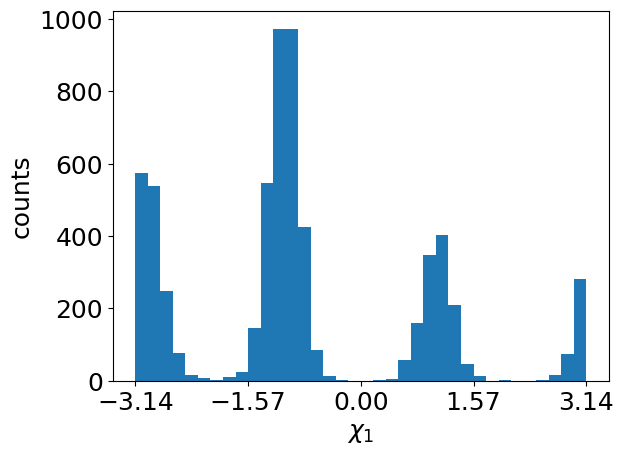

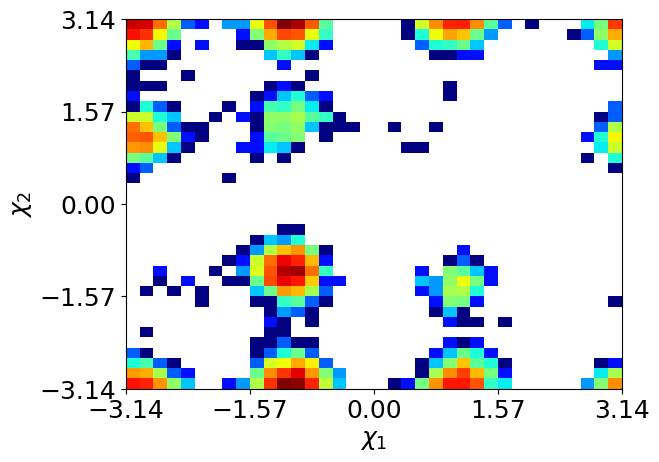

In [15]:
plot_phipsi(45)
plt.clf()
plot_chi(45)

In [16]:
xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [17]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 6280 frames, 35 atoms, 35 residues, and unitcells at 0x1ae549a4150>

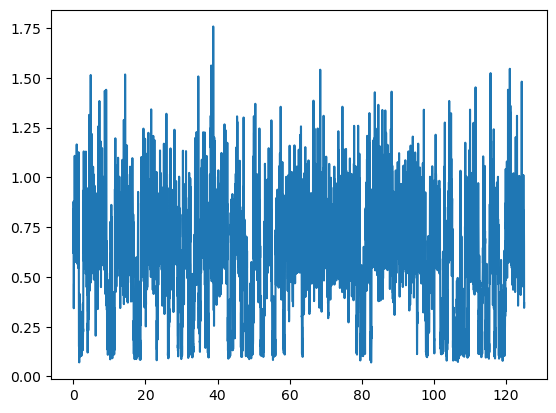

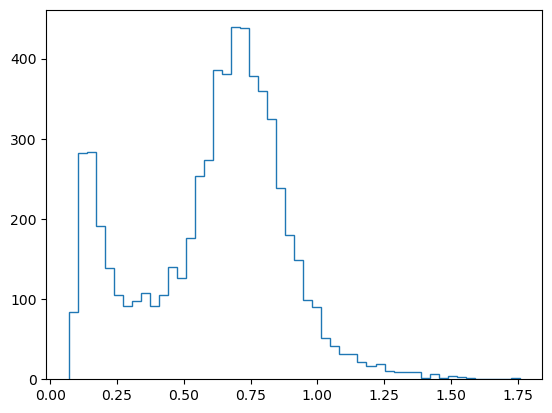

In [18]:
#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.show()

In [19]:
native_frames=np.where(rmsd<0.25)[0]
unfolded_frames=np.where(rmsd>0.60)[0]


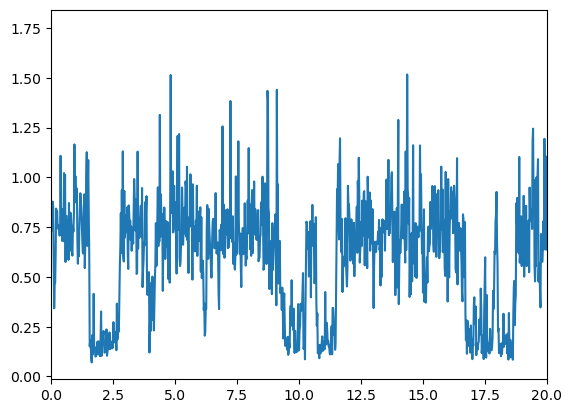

(array([ 84., 282., 283., 191., 139., 105.,  92.,  98., 108.,  92., 105.,
        140., 126., 176., 254., 274., 386., 381., 439., 438., 378., 359.,
        324., 238., 180., 149.,  99.,  90.,  52.,  42.,  32.,  32.,  22.,
         17.,  19.,  10.,   9.,   9.,   9.,   1.,   6.,   1.,   4.,   3.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([0.07021478, 0.10396621, 0.13771763, 0.17146906, 0.20522049,
        0.23897193, 0.27272335, 0.30647478, 0.3402262 , 0.37397766,
        0.40772909, 0.44148052, 0.47523195, 0.50898337, 0.5427348 ,
        0.57648623, 0.61023766, 0.64398909, 0.67774051, 0.71149194,
        0.74524337, 0.7789948 , 0.81274623, 0.84649765, 0.88024908,
        0.91400051, 0.94775194, 0.98150337, 1.01525486, 1.04900622,
        1.08275771, 1.11650908, 1.15026057, 1.18401194, 1.21776342,
        1.25151479, 1.28526628, 1.31901765, 1.35276914, 1.3865205 ,
        1.42027199, 1.45402336, 1.48777485, 1.52152622, 1.55527771,
        1.58902907, 1.62278056, 1.65653193, 1.

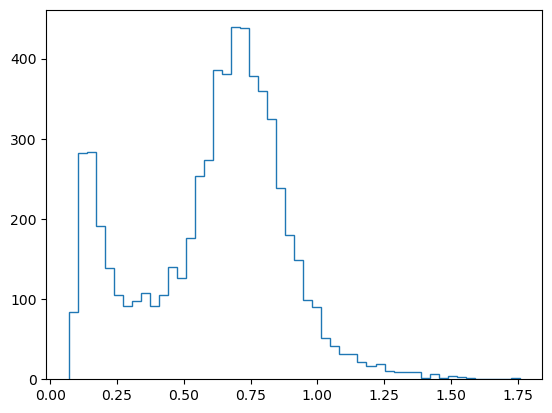

In [20]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

#CA_trj_sel=trj.topology.select("name CA")
#CA_xray_sel=xray_CA.topology.select("name CA")
rmsd = md.rmsd(trjCA,xray_CA)
plt.plot(time,rmsd)
plt.xlim(0,20)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)

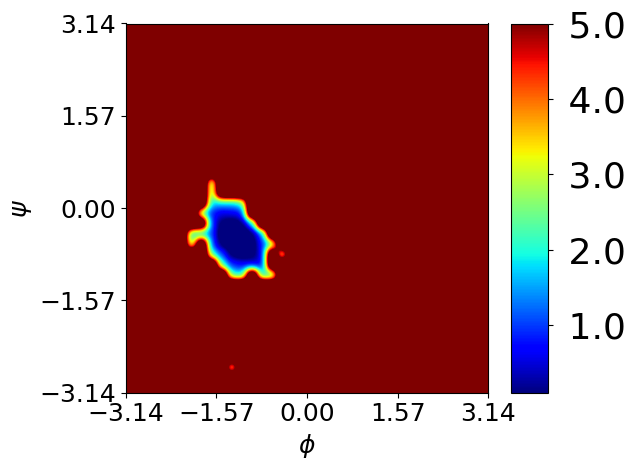

In [21]:
def plot_phipsi_FES_frames(res,frames):
 free_energy,xedges,yedges=np.histogram2d(dihedral_dict['psi'][res][frames],dihedral_dict['phi'][res][frames],36,[[-3.14,3.14],[-3.14,3.14]],density=True,weights=None)
 free_energy=np.log(np.flipud(free_energy)+.000001)
 T=300                                                                                                  
 kbT=T*0.008314/4.184 # kT in kcal/mol
 dG=-(kbT)*free_energy #Convert to kcal/mol
 im=plt.imshow(dG, interpolation='gaussian',extent=[yedges[0], yedges[-1], xedges[0], xedges[-1]],cmap='jet',aspect='auto')
 cbar_ticks=[0,1,2,3,4,5]
 cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'), aspect=10) # grab the Colorbar instance
 imaxes = plt.gca()                                                                                                 
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.tick_params(labelsize=18)
 plt.axes(cb.ax)
 plt.clim(vmin=0.1,vmax=5.0)
 plt.yticks(size='26')
 plt.tight_layout()
 plt.show()
 return


native_frames=np.where(rmsd<0.25)[0]
len(native_frames)
trj[native_frames].save_dcd(outdir+'native.dcd')

plot_phipsi_FES_frames(45,native_frames)


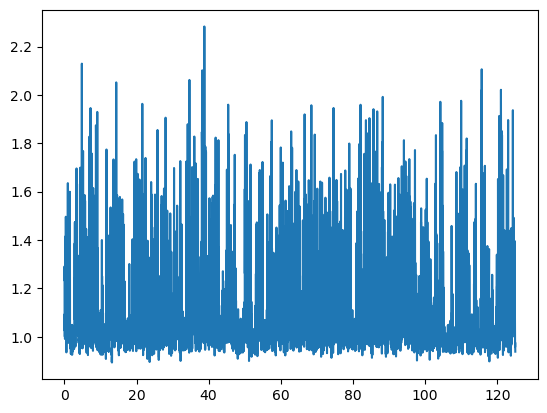

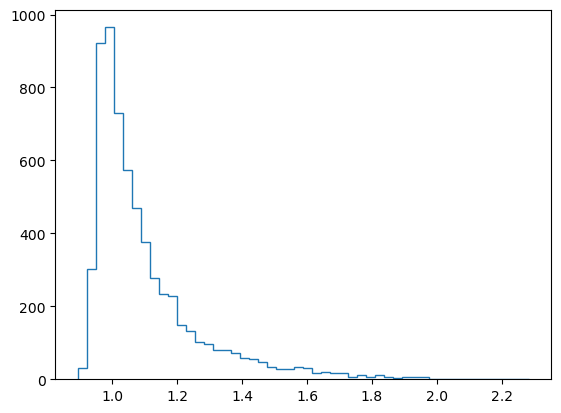

In [22]:
#Lets calculate the radius of gyration
rg=md.compute_rg(trj, masses=None)
plt.plot(time,rg)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.show()

In [23]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(6280, 2)


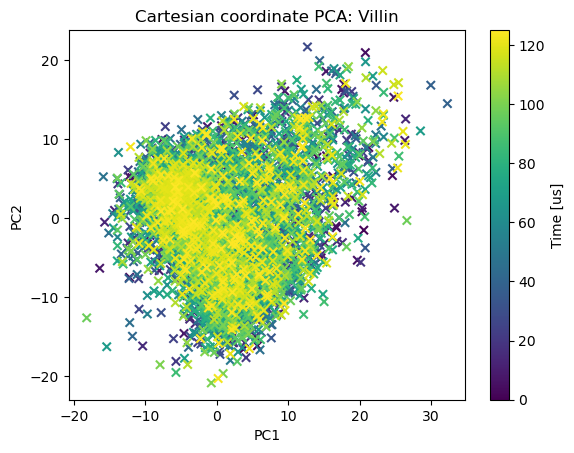

In [24]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Time [us]')

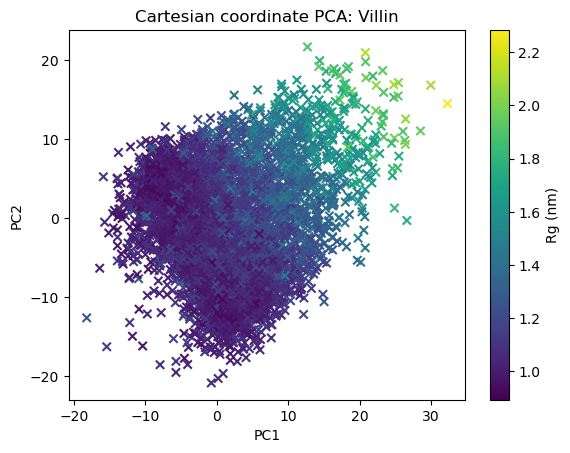

In [25]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rg)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Rg (nm)')

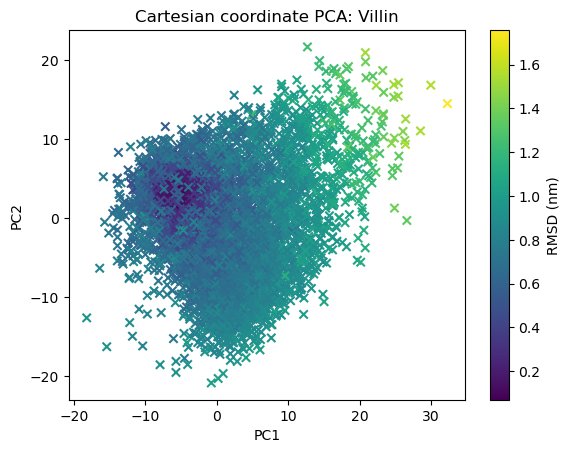

In [26]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

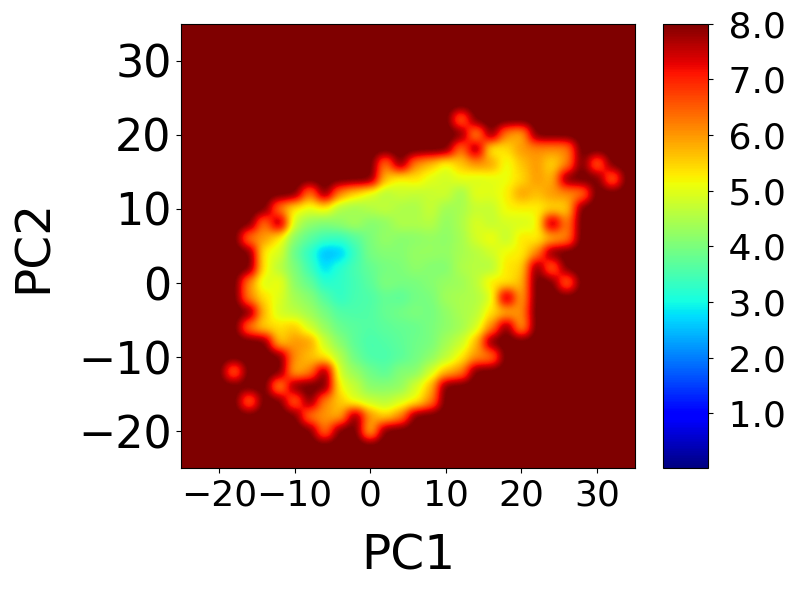

In [27]:
def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -25, 35, -25, 35)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

*** Classroom Activitiy: Lets plot the free energy as a function of RMSD***

In [28]:
#Lets Plot Free Energies as a function of RMSD and Rg

def free_energy1D(a,T,x0,xmax,bins):
    free_energy, xedges= np.histogram(
        a, bins, [x0, xmax], density=True, weights=None)
    xcenters= xedges[:-1] + np.diff(xedges)/2
    free_energy = np.log(free_energy+.0000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xcenters



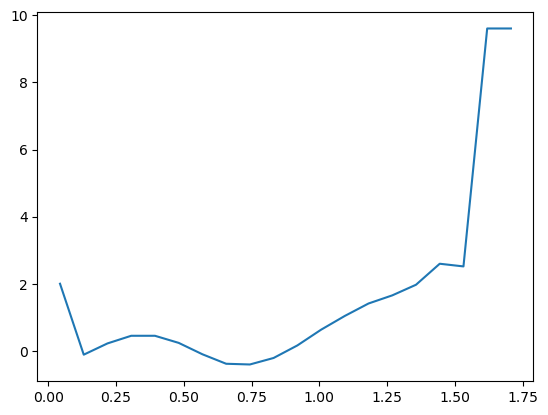

In [29]:
dG_RMSD,xedges=free_energy1D(rmsd,300,0,1.75,20)

plt.plot(xedges,dG_RMSD)

In [30]:
#Possible Homework Prompt:
#Visualize the lowest free energy basin
basin_frames=np.where((rmsd>0.60) & (rmsd<0.80))[0]
len(basin_frames)
trj[basin_frames].save_dcd(outdir+'rmsd.dgmin.basin.dcd')

*** Classroom Activitiy: Lets plot the free energy as a function of Rg vs. RMSD***

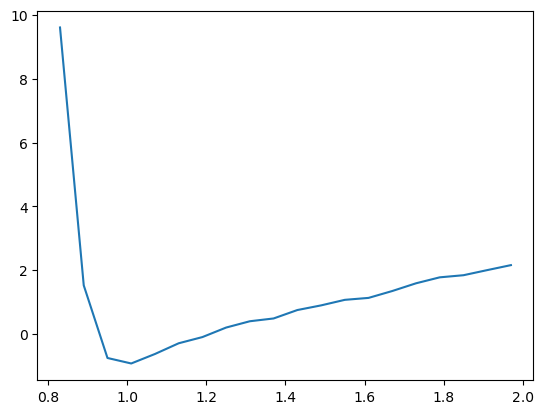

In [31]:
dG_rg,xedges=free_energy1D(rg,300,0.8,2.0,20)

plt.plot(xedges,dG_rg)

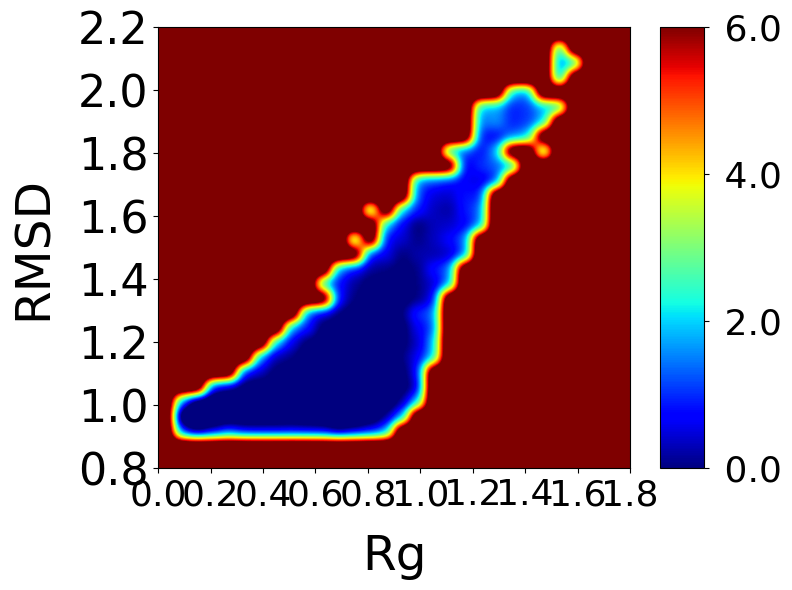

In [32]:
dG,xedges,yedges=free_energy(rg, rmsd, 300, 0.8, 2.2, 0, 1.8)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,2,4,6]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Rg", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0, vmax=6.0)
plt.yticks(size='26')
plt.tight_layout()

In [33]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)


In [34]:
#Lets Make Nice Contact Map Labels
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
#Lets Zero Out some of the Labels 
n=2
for i in range (0,len(sequence)): 
  if (i % n !=0):
   sequence[i]=''

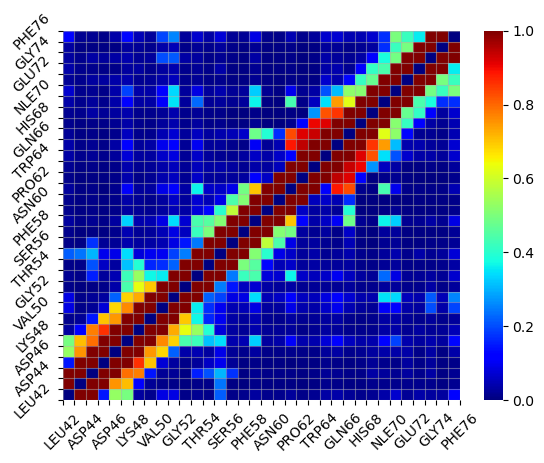

In [35]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

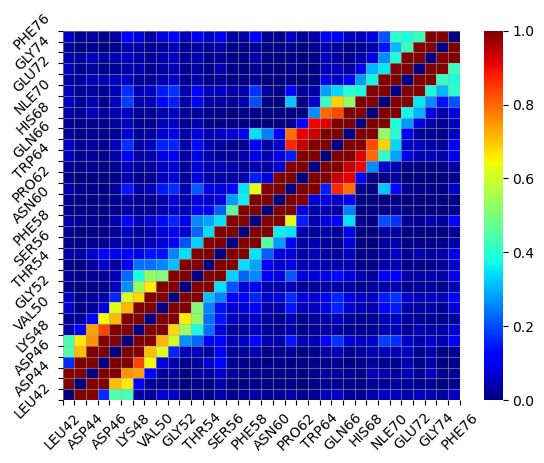

In [36]:
#Lets Make a Contact Map of the low dG Basin 
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[basin_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [37]:
#Now Lets Consider a "Native Portion of the Trajectory"
#Define Native Frames
native_frames

array([  79,   80,   81, ..., 6007, 6009, 6011], dtype=int64)

In [38]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [39]:
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10


In [40]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 1016)

In [41]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 550, 557,
       569, 570, 635, 636, 684], dtype=int64)

In [42]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(44, 6280)

In [43]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])

9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
10.452459 [ 9.374432 18.456451 13.714305 ... 11.399559  9.84092   8.788097]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
10.225195 [14.985344 16.675589 15.238585 ...  8.309675  8.071144  8.658443]
6.8318415 [12.484558  14.192814  12.563656  ...  5.9191756  5.

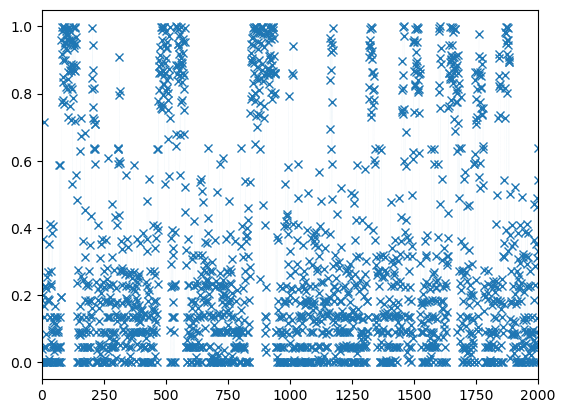

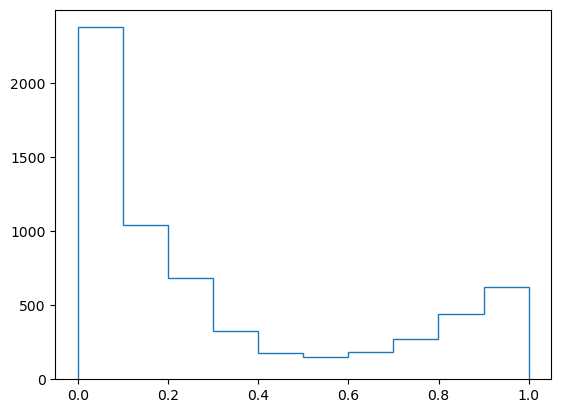

In [44]:
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

#Now Lets Consider a "Native Portion of the Trajectory"
#Define Native Frames
native_frames
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)
[4:23 PM] Paul Robustelli
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts
[4:23 PM] Paul Robustelli
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)
[4:24 PM] Paul Robustelli
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

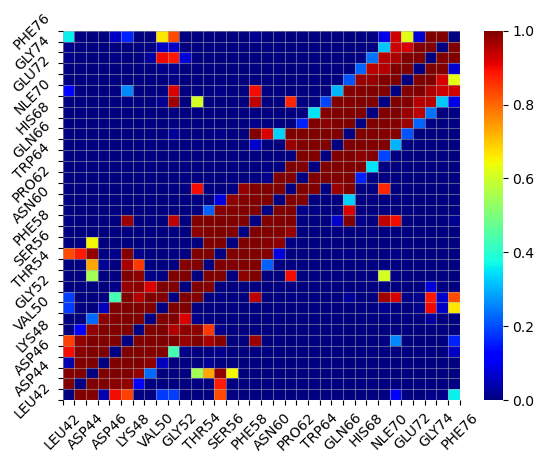

In [45]:
#Lets Make a Contact Map of the native frames
contact_maps = []
contact_distances = []

for i in range(0, 34):
    contact_map = []
    contact_distance = []
    for j in range(0, 34):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj[native_frames], [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,35))
ax.set_yticks(range(0,35))
ax.set_xticklabels(sequence[:35],rotation=45)
ax.set_yticklabels(sequence[:35],rotation=45)
plt.show()

In [46]:
def circular_mean(angle):
    return np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))


def circular_corr(angle1,angle2):
    cmean1=circular_mean(angle1)
    cmean2=circular_mean(angle2)
    numerator=(np.sum(np.sin(angle1-cmean1)*np.sin(angle2-cmean2)))
    denom=((np.sum(np.sin(angle1-cmean1)**2)*np.sum(np.sin(angle2-cmean2)**2))**.5)
    ccor=numerator/denom
    return ccor

In [47]:
# Make correlation contact map
correlation_maps = []
for i in range(43, 76):
    cor_map = []
    for j in range(43, 76):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        ccor=circular_corr(psi,phi)
        cor_map.append(ccor)
    correlation_maps.append(cor_map)
final_cor_map = np.asarray(correlation_maps).astype(float)
np.shape(final_map)

(34, 34)

In [48]:
sequence=[]
for residue in trj.topology.residues:
    sequence.append(residue)
len(sequence)
seq_trunc=sequence[1:34]
#Lets Zero Out some of the Labels 
n=2
for i in range (0,33): 
  if (i % n !=0):
   seq_trunc[i]=''

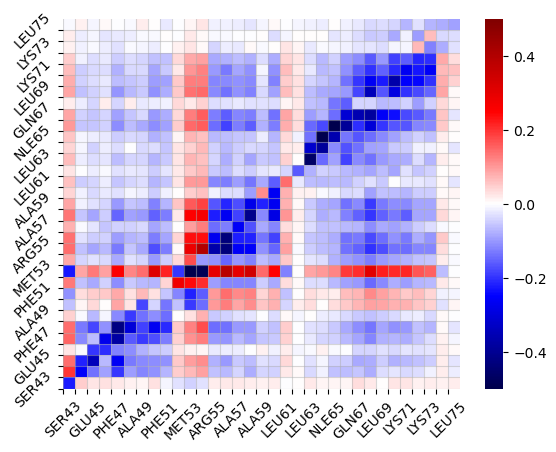

In [49]:
mask = np.zeros_like(final_map)
zeros=np.where((final_map<0.10) & (final_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

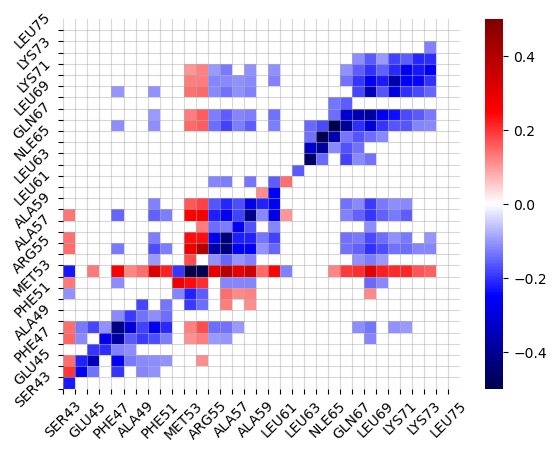

In [50]:
mask = np.zeros_like(final_cor_map)
zeros=np.where((final_cor_map<0.10) & (final_cor_map>-0.10))
mask[zeros] = True
ax = sns.heatmap(final_cor_map,mask=mask, vmin=-0.5, vmax=0.5,cmap='seismic')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)
ax.set_xticks(range(0,33))
ax.set_yticks(range(0,33))
ax.set_xticklabels(seq_trunc,rotation=45)
ax.set_yticklabels(seq_trunc,rotation=45)
plt.show()

We want to try to Reproduce the Free Energy Plot From
https://www.science.org/doi/full/10.1126/science.1208351

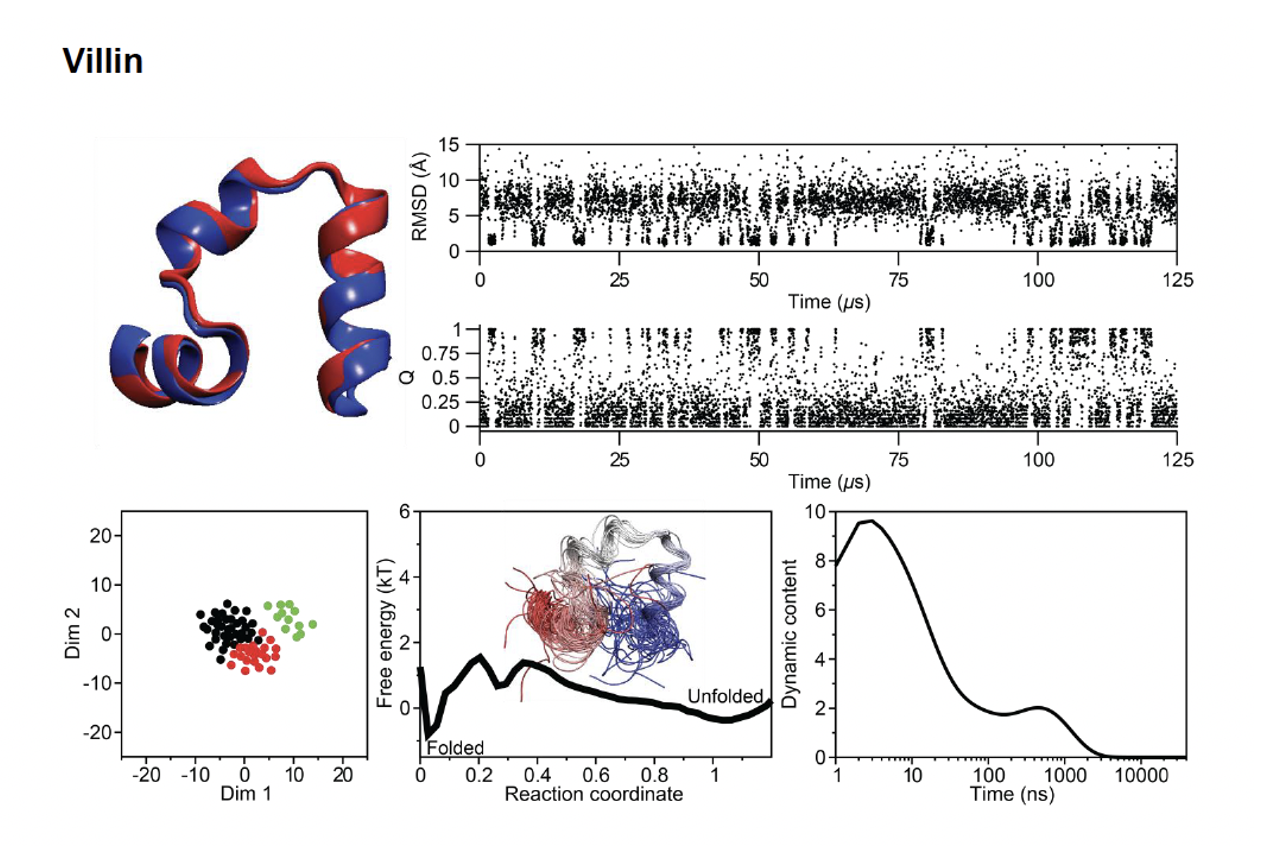

First we need to determine the native contacts and calculate Q

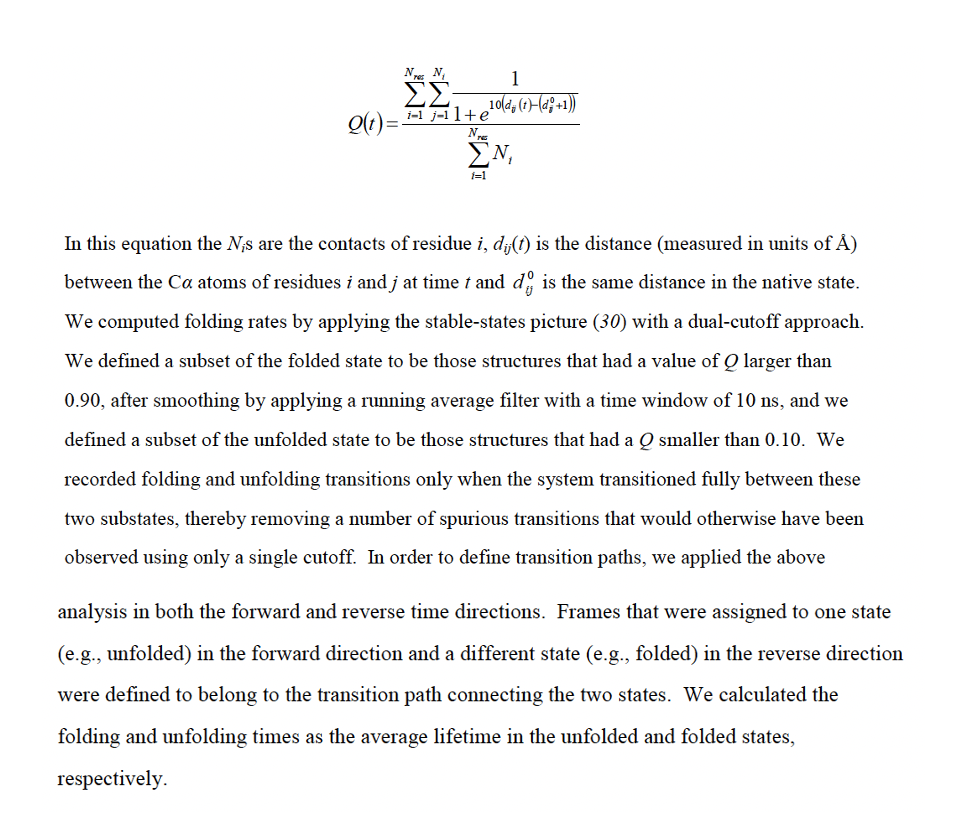

In [51]:
#Lets Make a 1D array that contains all native distances pairs:
xray_CA

<mdtraj.Trajectory with 1 frames, 35 atoms, 35 residues, and unitcells at 0x1ae54957110>

In [52]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [53]:
Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)

(148,)

In [54]:
Native_Contacts

(array([  0,   5,  30,  52,  53,  54,  55,  75,  76,  77,  78,  98, 100,
        103, 104, 120, 121, 123, 124, 125, 141, 142, 143, 145, 161, 162,
        163, 164, 180, 181, 182, 183, 184, 185, 192, 193, 196, 198, 201,
        202, 203, 208, 211, 212, 214, 215, 221, 239, 240, 258, 259, 260,
        275, 276, 277, 278, 280, 296, 297, 298, 299, 300, 319, 320, 337,
        338, 339, 340, 341, 344, 348, 355, 356, 358, 359, 360, 367, 368,
        369, 374, 375, 376, 377, 378, 379, 380, 385, 386, 387, 397, 398,
        404, 405, 406, 416, 421, 422, 423, 424, 425, 441, 442, 443, 444,
        445, 461, 462, 463, 481, 493, 500, 501, 521, 549, 550, 557, 569,
        570, 581, 602, 603, 613, 622, 623, 624, 625, 626, 635, 636, 643,
        644, 645, 646, 647, 648, 649, 650, 668, 669, 670, 671, 672, 673,
        675, 684, 693, 697, 701], dtype=int64),)

In [55]:
traj_CA_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]


In [56]:
np.shape(Traj_Native_Contact_Distances)

(148, 6280)

In [57]:
for i in range(0,len(Native_Contact_Distances)):
  print(Native_Contact_Distances[i],Traj_Native_Contact_Distances[i])

9.288557 [16.155031 10.791452 12.989177 ...  9.819974 13.44309  12.631355]
9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.792495 [17.497013 20.938164 14.502391 ...  9.647299 10.491154 12.31331 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
7.2052145 [18.622604 19.704548 15.620064 ... 10.816223 11.794368

In [58]:
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_Native_Contact_Distances))
for i in range(0,len(Native_Contact_Distances)):
 Native_Contact_Distances_nframes[i]=Native_Contact_Distances[i]

In [59]:

Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(148, 6280)

In [60]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])

9.288557 [16.155031 10.791452 12.989177 ...  9.819974 13.44309  12.631355]
9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.792495 [17.497013 20.938164 14.502391 ...  9.647299 10.491154 12.31331 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
7.2052145 [18.622604 19.704548 15.620064 ... 10.816223 11.794368

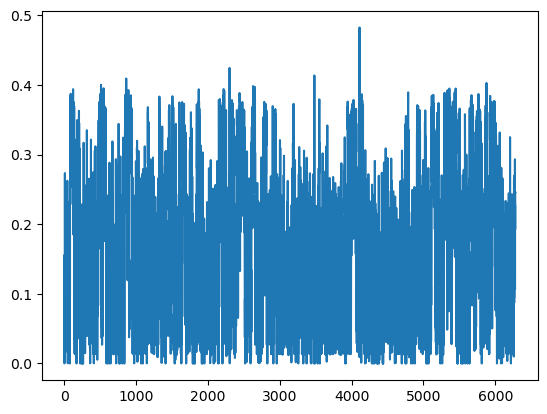

(array([1.087e+03, 1.503e+03, 9.610e+02, 6.850e+02, 4.700e+02, 4.940e+02,
        5.690e+02, 4.810e+02, 2.900e+01, 1.000e+00]),
 array([1.28075769e-25, 4.82478970e-02, 9.64957939e-02, 1.44743691e-01,
        1.92991588e-01, 2.41239485e-01, 2.89487382e-01, 3.37735279e-01,
        3.85983176e-01, 4.34231073e-01, 4.82478970e-01]),
 [<matplotlib.patches.Polygon at 0x1ae53b027d0>])

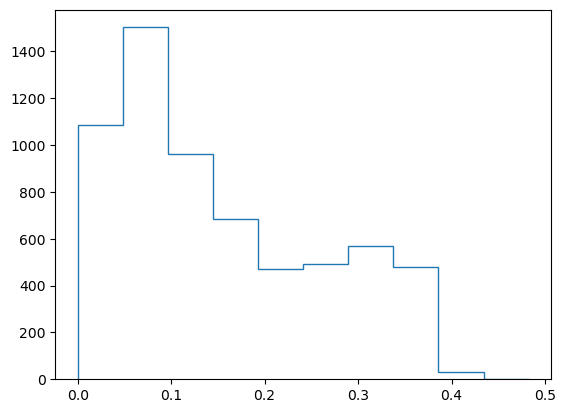

In [64]:
Q=1/(1+np.exp(10*(Traj_Native_Contact_Distances-(Native_Contact_Distances_nframes+1))))

Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_Contact_Distances)
plt.plot(Q)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')

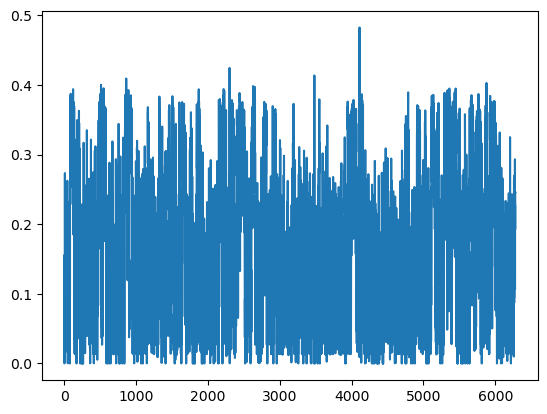

(array([1.087e+03, 1.503e+03, 9.610e+02, 6.850e+02, 4.700e+02, 4.940e+02,
        5.690e+02, 4.810e+02, 2.900e+01, 1.000e+00]),
 array([1.28075769e-25, 4.82478970e-02, 9.64957939e-02, 1.44743691e-01,
        1.92991588e-01, 2.41239485e-01, 2.89487382e-01, 3.37735279e-01,
        3.85983176e-01, 4.34231073e-01, 4.82478970e-01]),
 [<matplotlib.patches.Polygon at 0x1ae562bd450>])

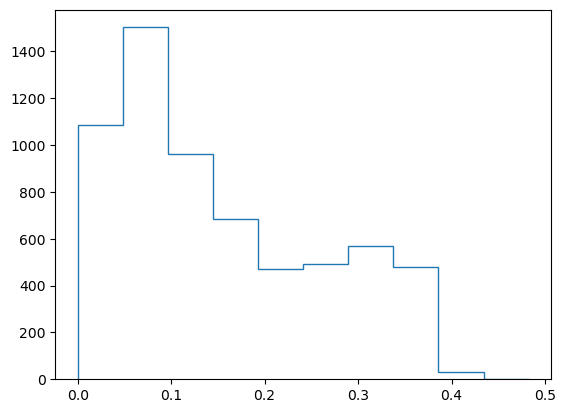

In [65]:
Q=1/(1+np.exp(10*(Traj_Native_Contact_Distances-(Native_Contact_Distances_nframes+1))))

Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_Contact_Distances)
plt.plot(Q)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')

In [66]:
#Now Lets Consider a "Native Portion of the Trajectory"
native_frames

array([  79,   80,   81, ..., 6007, 6009, 6011], dtype=int64)

In [67]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10


In [68]:
np.shape(native_distance_matrix1D)

(702,)

In [69]:
np.shape(traj_CA_distance_matrix1D)

(702, 6280)

In [70]:
#Select Only the Frames with low RMSD from native state
trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]
np.shape(trj_native_distances)

(702, 1016)

In [71]:
averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]
Native_Contacts

array([  5,  29,  30,  52,  53,  54,  55,  75,  76,  77,  98,  99, 120,
       123, 193, 196, 198, 211, 212, 215, 239, 240, 257, 258, 259, 260,
       275, 276, 277, 278, 279, 280, 296, 337, 341, 344, 500, 550, 557,
       569, 570, 635, 636, 684], dtype=int64)

In [72]:
Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]
#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)

(44, 6280)

In [73]:
for i in range(0,len(Native_CA_Distances)):
  print(Native_CA_Distances[i],Traj_CA_Distnaces[i])

9.985726 [11.540491 20.317595 20.025805 ... 11.637041 11.133914  9.529006]
10.452459 [ 9.374432 18.456451 13.714305 ... 11.399559  9.84092   8.788097]
9.704253 [11.477718 20.877588 17.621155 ...  9.078924  8.659006  7.693935]
9.60349 [ 9.620813 13.511494 10.39926  ... 10.133906  9.546892  7.720747]
7.0967283 [ 8.358078  16.181501   9.917504  ...  8.583042   6.1711082  5.1262226]
7.0852814 [10.051856  18.739012  13.814268  ...  5.561247   5.1992693  5.3546863]
9.99271 [13.804028  21.581156  13.504515  ...  6.8650303  7.900141   8.60963  ]
9.574567 [12.595353  12.5168705 11.052504  ... 10.495369   8.90573    9.204168 ]
8.303897 [11.918608  15.800192   9.9505415 ...  9.353915   6.660173   7.861574 ]
9.653462 [13.711605  17.694164  13.798973  ...  6.8816047  7.4799404  8.898192 ]
9.633482 [12.349012 14.908751 11.635593 ...  9.368454  8.254533  8.578752]
10.225195 [14.985344 16.675589 15.238585 ...  8.309675  8.071144  8.658443]
6.8318415 [12.484558  14.192814  12.563656  ...  5.9191756  5.

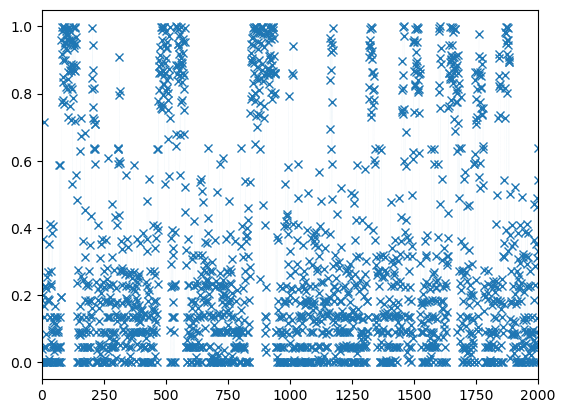

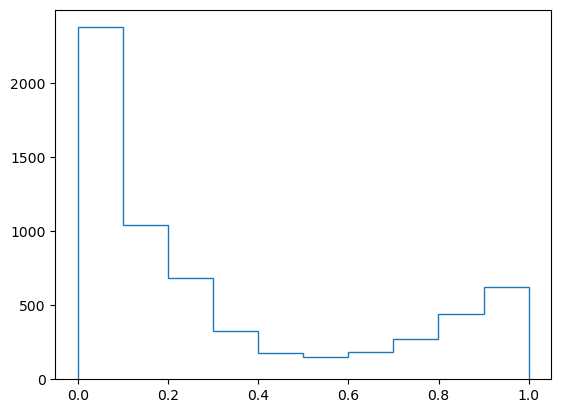

In [74]:
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

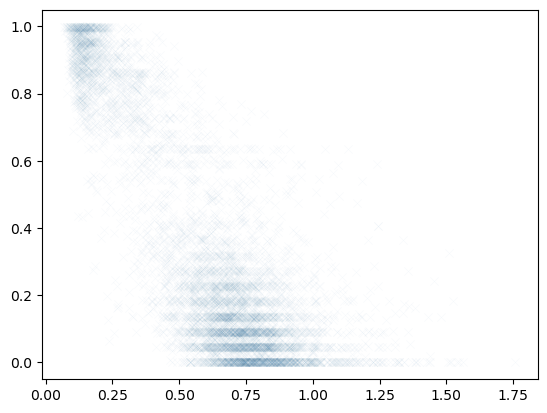

In [75]:
#Plot Q and a Histogram
plt.scatter(rmsd,Q,marker='x',linewidth=.01)

In [76]:
dG,xedges,yedges=free_energy(rmsd, Q, 300, 0, 2.0, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0,1,2]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("RMSD", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=2.0)
plt.yticks(size='26')
plt.tight_layout()

In [77]:
dG_Q,xedges=free_energy1D(Q,300,0,1,20)

plt.plot(xedges,dG_Q)
plt.xlabel("Q",size=15)
plt.ylabel("$\Delta$G",size=15)

Text(0, 0.5, '$\\Delta$G')

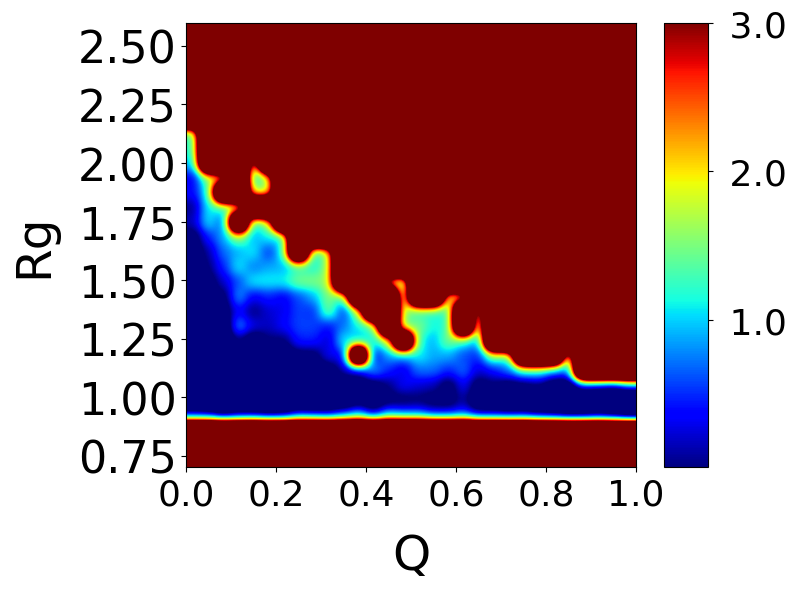

In [78]:
dG,xedges,yedges=free_energy(rg, Q, 300, 0.7, 2.6, 0, 1)

fig = plt.figure(figsize=(8, 6))
#im = plt.imshow(dG, extent=[
#                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2,3]
#plt.xlim(-25,35)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("Rg", size=35, labelpad=15)
plt.xlabel("Q", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=3.0)
plt.yticks(size='26')
plt.tight_layout()

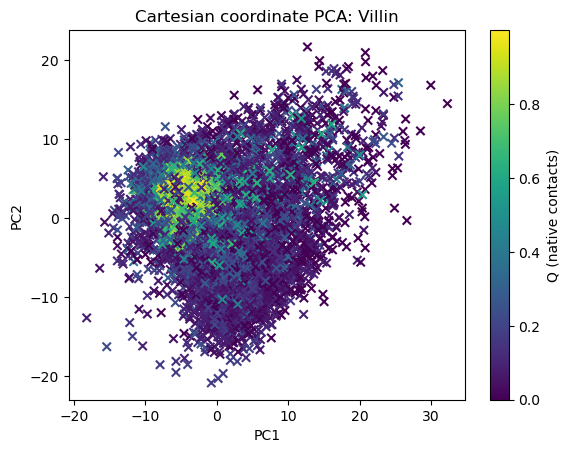

In [79]:
### plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=Q)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Villin')
cbar = plt.colorbar()
cbar.set_label('Q (native contacts)')

HOMEWORK 4


In [80]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
native_frames

array([  79,   80,   81, ..., 6007, 6009, 6011], dtype=int64)

In [81]:
Traj_CA_Distnaces.shape

(44, 6280)

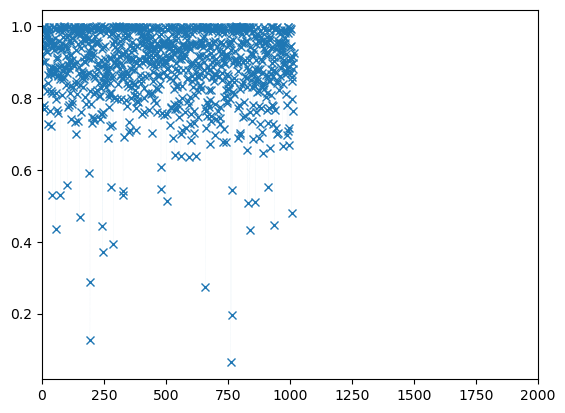

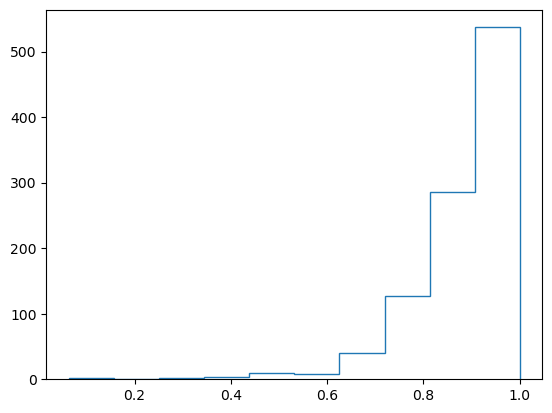

In [82]:
#select only the native frames from Traj_CA_Distnaces
Q=1/(1+np.exp(10*(Traj_CA_Distnaces[:,native_frames]-(Native_Contact_Distances_nframes[:,native_frames]+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
plt.plot(Q,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()
plt.clf()
plt.hist(Q,histtype='step')
plt.show()

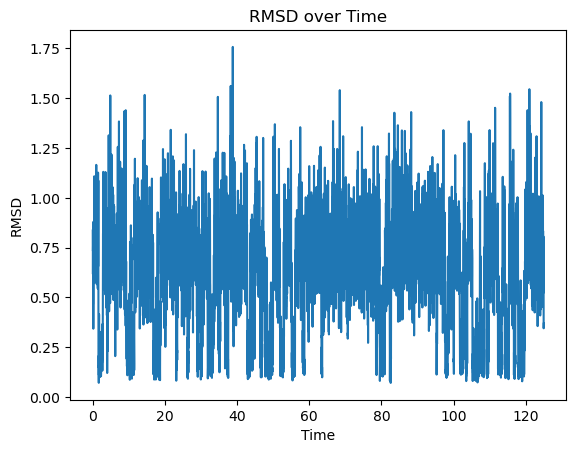

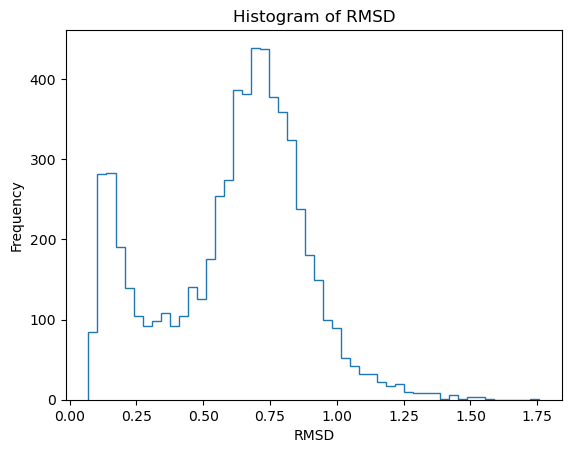

Selected frames with low RMSD from native state: [79, 80, 81, 82, 83, 84, 85, 86, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 200, 203, 209, 312, 313, 471, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 491, 493, 494, 495, 496, 497, 498, 499, 500, 502, 503, 504, 512, 513, 514, 515, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 557, 558, 560, 561, 562, 563, 564, 565, 566, 567, 568, 570, 574, 576, 577, 841, 843, 845, 846, 847, 848, 849, 850, 852, 853, 854, 855, 856, 862, 863, 864, 865, 866, 867, 869, 870, 873, 874, 875, 876, 877, 881, 882, 884, 885, 886, 887, 888, 889, 890, 891, 892, 893, 894, 895, 906, 907, 908, 909, 910, 911, 912, 913, 914, 915, 916, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 929, 930, 931, 932, 933, 934, 935, 936, 1162, 1164, 1165, 1166, 1171, 1172,

In [84]:
#Select Only the Frames with low RMSD from native state for the native distances
def select_low_rmsd_frames(trjCA, xray_CA, native_frames, threshold):
    # Calculate RMSD between trajectory and native structure
    rmsd = md.rmsd(trjCA, xray_CA)
    
    # Plot RMSD over time
    plt.plot(time, rmsd)
    plt.xlabel('Time')
    plt.ylabel('RMSD')
    plt.title('RMSD over Time')
    plt.show()
    plt.clf()
    
    # Plot histogram of RMSD values
    plt.hist(rmsd, histtype='step', bins=50)
    plt.xlabel('RMSD')
    plt.ylabel('Frequency')
    plt.title('Histogram of RMSD')
    plt.show()
    
    # Select frames with RMSD below the threshold
    low_rmsd_frames = [frame for frame, rmsd_value in enumerate(rmsd) if rmsd_value < threshold]
    
    # Select only the frames with low RMSD from the native state
    low_rmsd_native_frames = [frame for frame in low_rmsd_frames if frame in native_frames]
    
    return low_rmsd_native_frames

# Example usage
trj_native_distances = traj_CA_distance_matrix1D[:, native_frames]
threshold = 0.5  # Set your desired threshold here
selected_frames = select_low_rmsd_frames(trjCA, xray_CA, native_frames, threshold)
print("Selected frames with low RMSD from native state:", selected_frames)


In [ ]:
#Filter the native distances to only include distances where the average value < 10A in the native frames 


In [ ]:
#Check that we're comparing all the correct distances 


In [105]:


def plot_Q(traj_CA_distance_matrix1D, native_frames, Native_Contact_Distances_nframes, Native_CA_Distances):
    trj_native_distances = traj_CA_distance_matrix1D[:, native_frames]
    Q = 1 / (1 + np.exp(10 * (trj_native_distances - (Native_Contact_Distances_nframes[:, native_frames] + 1))))
    Q_sum = np.sum(Q, axis=0)
    Q = Q_sum / len(Native_CA_Distances)
    
    plt.figure(figsize=(10, 5))
    plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
    plt.subplot(1, 2, 1)
    plt.plot(Q, marker='x', linewidth=0.01)
    plt.title('Q Plot')
    plt.xlabel('Frame')
    plt.ylabel('Q Value')
    plt.xlim(0, 2000)
    
    plt.subplot(1, 2, 2)
    plt.hist(Q, histtype='step')
    plt.title('Q Histogram')
    plt.xlabel('Q Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()



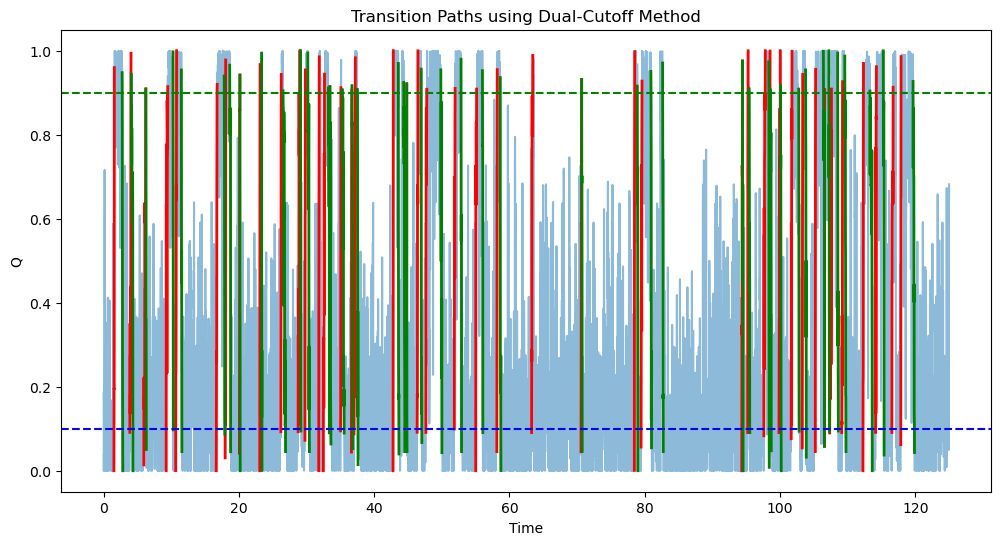

In [95]:
#Plot transition path

time=np.linspace(0,125,n_frames)
Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)
# Organize Q values
Q_add_m1s = np.where(Q < 0.10, -1, Q)
Q_add_1s = np.where(Q_add_m1s > 0.90, 1, Q_add_m1s)
Q_add_0s = np.where((Q_add_1s != 1) & (Q_add_1s != -1), 0, Q_add_1s)
# Define cutoff thresholds
folded_threshold = 0.9
unfolded_threshold = 0.1
# Identify folding and unfolding paths
folding_paths = []
unfolding_paths = []
in_transition = False
start_index = None
for i in range(1, len(Q_add_0s)):
    if Q_add_0s[i-1] == -1 and Q_add_0s[i] == 0:
        in_transition = True
        start_index = i-1
    elif in_transition and Q_add_0s[i] == 1:
        if Q_add_0s[start_index:i].tolist().count(1) == 0:
            end_index = i
            folding_paths.append((time[start_index], time[end_index]))
        in_transition = False
    elif Q_add_0s[i-1] == 1 and Q_add_0s[i] == 0:
        in_transition = True
        start_index = i-1
    elif in_transition and Q_add_0s[i] == -1:
        if Q_add_0s[start_index:i].tolist().count(-1) == 0:
            end_index = i
            unfolding_paths.append((time[start_index], time[end_index]))
        in_transition = False
# Plot the transition paths
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for start, end in folding_paths:
    transition_indices = (time >= start) & (time <= end)
    plt.plot(time[transition_indices], Q[transition_indices], color='red', linewidth=2, label='Folding Path')
# Highlight unfolding paths
for start, end in unfolding_paths:
    transition_indices = (time >= start) & (time <= end)
    plt.plot(time[transition_indices], Q[transition_indices], color='green', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.ylabel('Q')
plt.title('Transition Paths using Dual-Cutoff Method')
plt.show()
window_size = 5


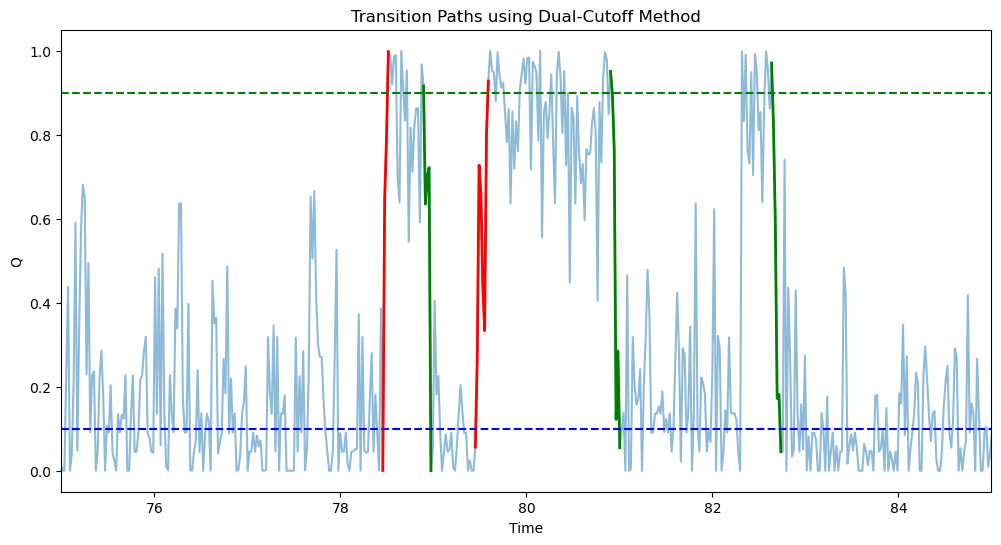

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for start, end in folding_paths:
    transition_indices = (time >= start) & (time <= end)
    plt.plot(time[transition_indices], Q[transition_indices], color='red', linewidth=2, label='Folding Path')
# Highlight unfolding paths
for start, end in unfolding_paths:
    transition_indices = (time >= start) & (time <= end)
    plt.plot(time[transition_indices], Q[transition_indices], color='green', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.ylabel('Q')
plt.xlim(75,85)
plt.title('Transition Paths using Dual-Cutoff Method')
plt.show()

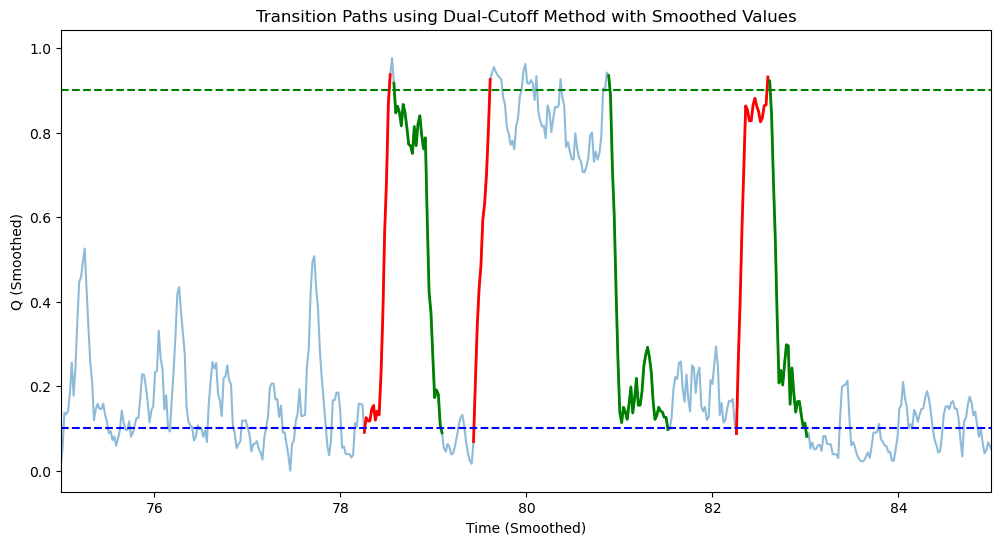

In [126]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations
# Define smoothing window size
window_size = 5
# Smooth Q values
smoothed_Q = np.convolve(Q, np.ones(window_size)/window_size, mode='valid')
# Smooth time values
smoothed_time = np.convolve(time, np.ones(window_size)/window_size, mode='valid')
# Identify folding and unfolding paths using smoothed Q values
folding_paths_smoothed = []
unfolding_paths_smoothed = []
in_transition = False
start_index = None
for i in range(1, len(smoothed_Q)):
    if smoothed_Q[i-1] < unfolded_threshold and smoothed_Q[i] >= unfolded_threshold:
        in_transition = True
        start_index = i-1
    elif in_transition and smoothed_Q[i] >= folded_threshold:
        if np.all(smoothed_Q[start_index:i] < folded_threshold):
            end_index = i
            folding_paths_smoothed.append((smoothed_time[start_index], smoothed_time[end_index]))
        in_transition = False
    elif smoothed_Q[i-1] > folded_threshold and smoothed_Q[i] <= folded_threshold:
        in_transition = True
        start_index = i-1
    elif in_transition and smoothed_Q[i] <= unfolded_threshold:
        if np.all(smoothed_Q[start_index:i] > unfolded_threshold):
            end_index = i
            unfolding_paths_smoothed.append((smoothed_time[start_index], smoothed_time[end_index]))
        in_transition = False
# Plot the transition paths with smoothed values
plt.figure(figsize=(12, 6))
plt.plot(smoothed_time, smoothed_Q, label='Smoothed Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for start, end in folding_paths_smoothed:
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='red', linewidth=2, label='Folding Path')
# Highlight unfolding paths
for start, end in unfolding_paths_smoothed:
    plt.plot(smoothed_time[(smoothed_time >= start) & (smoothed_time <= end)],
             smoothed_Q[(smoothed_time >= start) & (smoothed_time <= end)],
             color='green', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time (Smoothed)')
plt.ylabel('Q (Smoothed)')
plt.xlim(75,85)
plt.title('Transition Paths using Dual-Cutoff Method with Smoothed Values')
plt.show()


In [127]:
print("Long Folding Paths:", long_folding_paths)
print("Short Folding Paths:", short_folding_paths)
print("Long Unfolding Paths:", long_unfolding_paths)
print("Short Unfolding Paths:", short_unfolding_paths)

Long Folding Paths: [(8.898709985666507, 9.595476986781335), (16.264532568880394, 16.881669055582098), (31.75266762223284, 32.86749482401656), (112.21930243669374, 112.81653129479216), (113.73228221054308, 114.3295110686415), (116.22073578595318, 116.8179646440516)]
Short Folding Paths: [(1.3338111164198119, 1.612517916865743), (10.610766045548655, 10.80984233158146), (17.93677337155598, 18.076126771778945), (25.91973244147157, 26.297977384933905), (29.64245899028508, 30.04061156235069), (36.96846631629241, 37.20735785953177), (42.74167861124383, 42.861124382863515), (43.99585921325051, 44.19493549928333), (46.325051759834366, 46.74311196050326), (47.43987896161809, 47.79821627647715), (51.70011148272018, 52.05844879757923), (54.82560917343526, 55.18394648829431), (57.8913839783405, 58.22981366459627), (63.107182672400064, 63.4854276158624), (78.25688803949674, 78.53559483994266), (79.4314381270903, 79.61060678451983), (82.25832138875617, 82.59675107501194), (95.1783723522854, 95.29781

In [116]:
#Define thresholds for path duration
short_path_threshold = .2
long_path_threshold = .5
# Initialize lists to store longer and shorter paths
long_folding_paths = []
short_folding_paths = []
long_unfolding_paths = []
short_unfolding_paths = []
# Iterate through folding paths to categorize them as long or short
for start, end in folding_paths_smoothed:
    path_duration = end - start
    if path_duration > long_path_threshold:
        long_folding_paths.append((start, end))
    else:
        short_folding_paths.append((start, end))
# Iterate through unfolding paths to categorize them as long or short
for start, end in unfolding_paths_smoothed:
    path_duration = end - start
    if path_duration > long_path_threshold:
        long_unfolding_paths.append((start, end))
    else:
        short_unfolding_paths.append((start, end))
# Print or use the categorized paths as needed
print("Long Folding Paths:", long_folding_paths)
print("Short Folding Paths:", short_folding_paths)
print("Long Unfolding Paths:", long_unfolding_paths)
print("Short Unfolding Paths:", short_unfolding_paths)
#Plot transition path (long or short)
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for start, end in folding_paths:
    plt.plot(time[(time >= start) & (time <= end)],
             Q[(time >= start) & (time <= end)],
             color='red', linewidth=2, label='Folding Path')
# Highlight unfolding paths
for start, end in unfolding_paths:
    plt.plot(time[(time >= start) & (time <= end)],
             Q[(time >= start) & (time <= end)],
             color='green', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
#adjusting x limit to show path of interest
plt.xlim(31.75,32.86)
plt.ylabel('Q')
plt.title('Long Folding Transition Path ')
plt.show()



Long Folding Paths: [(8.898709985666507, 9.595476986781335), (16.264532568880394, 16.881669055582098), (31.75266762223284, 32.86749482401656), (112.21930243669374, 112.81653129479216), (113.73228221054308, 114.3295110686415), (116.22073578595318, 116.8179646440516)]
Short Folding Paths: [(1.3338111164198119, 1.612517916865743), (10.610766045548655, 10.80984233158146), (17.93677337155598, 18.076126771778945), (25.91973244147157, 26.297977384933905), (29.64245899028508, 30.04061156235069), (36.96846631629241, 37.20735785953177), (42.74167861124383, 42.861124382863515), (43.99585921325051, 44.19493549928333), (46.325051759834366, 46.74311196050326), (47.43987896161809, 47.79821627647715), (51.70011148272018, 52.05844879757923), (54.82560917343526, 55.18394648829431), (57.8913839783405, 58.22981366459627), (63.107182672400064, 63.4854276158624), (78.25688803949674, 78.53559483994266), (79.4314381270903, 79.61060678451983), (82.25832138875617, 82.59675107501194), (95.1783723522854, 95.29781

In [122]:
#Plot transition path (long or short)
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for start, end in folding_paths:
    plt.plot(time[(time >= start) & (time <= end)],
             Q[(time >= start) & (time <= end)],
             color='red', linewidth=2, label='Folding Path')
# Highlight unfolding paths
for start, end in unfolding_paths:
    plt.plot(time[(time >= start) & (time <= end)],
             Q[(time >= start) & (time <= end)],
             color='green', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.xlim(17.93,18.07)
plt.ylabel('Q')
plt.title('Short Folding Transition Path ')
plt.show()

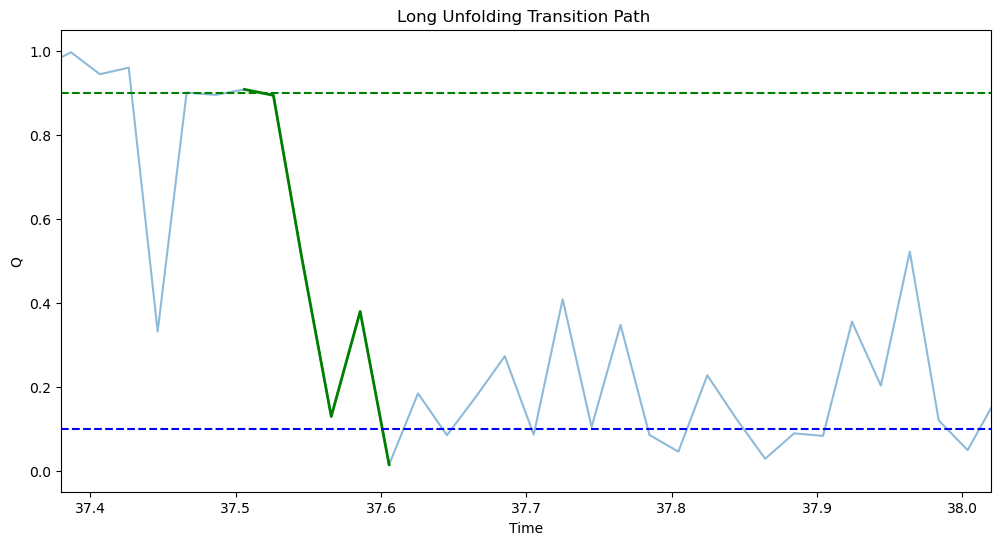

In [120]:
#Plot transition path (long or short)
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for start, end in folding_paths:
    plt.plot(time[(time >= start) & (time <= end)],
             Q[(time >= start) & (time <= end)],
             color='red', linewidth=2, label='Folding Path')
# Highlight unfolding paths
for start, end in unfolding_paths:
    plt.plot(time[(time >= start) & (time <= end)],
             Q[(time >= start) & (time <= end)],
             color='green', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.xlim(37.38,38.02)
plt.ylabel('Q')
plt.title('Long Unfolding Transition Path ')
plt.show()

In [123]:
#Plot transition path (long or short)
plt.figure(figsize=(12, 6))
plt.plot(time, Q, label='Q (Reaction Coordinate)', alpha=0.5)
# Highlight folding paths
for start, end in folding_paths:
    plt.plot(time[(time >= start) & (time <= end)],
             Q[(time >= start) & (time <= end)],
             color='red', linewidth=2, label='Folding Path')
# Highlight unfolding paths
for start, end in unfolding_paths:
    plt.plot(time[(time >= start) & (time <= end)],
             Q[(time >= start) & (time <= end)],
             color='green', linewidth=2, label='Unfolding Path')
# Mark thresholds for folded and unfolded states
plt.axhline(folded_threshold, color='g', linestyle='--', label='Folded Threshold')
plt.axhline(unfolded_threshold, color='b', linestyle='--', label='Unfolded Threshold')
# Customize the plot
plt.xlabel('Time')
plt.xlim(17.77,17.93)
plt.ylabel('Q')
plt.title('Short Unfolding Transition Path ')
plt.show()

In [131]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

In [128]:
#Find the secondary structure definition
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'C', 'C', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'H', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'H', ..., 'NA', 'NA', 'NA'],
       ...,
       ['C', 'C', 'H', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'C', ..., 'NA', 'NA', 'NA'],
       ['C', 'C', 'H', ..., 'NA', 'NA', 'NA']], dtype='<U2')

In [134]:
print(dssp.shape)
print("Rows:",len(dssp))
print("Columns:",len(dssp[0]))

#Print out helix and beta residues for a given frame
frame=0
dssp_frame=np.column_stack((residue_id,dssp[frame]))
helix_res=np.where(dssp_frame[:,1]=='H')
print('helical residues:',dssp_frame[helix_res])

(6280, 70)
Rows: 6280
Columns: 70
helical residues: [['57' 'H']
 ['58' 'H']
 ['59' 'H']]


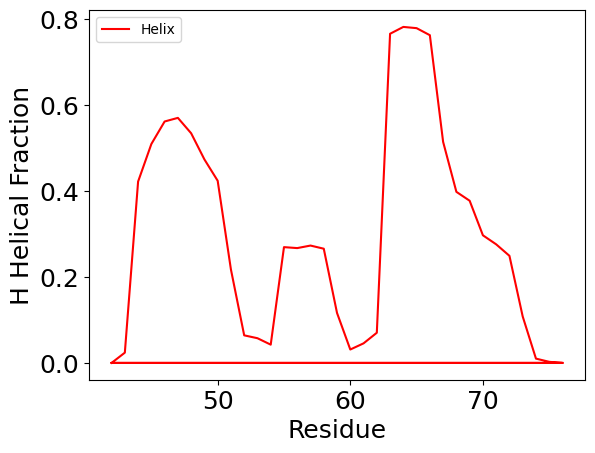

In [130]:
##HW1a
####HOMEWORK ######
#Use the full DSSP Definition and plot the population of another secondary structure type 
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html

dssp_full=md.compute_dssp(trj,simplified=False)

#Isolate the population of S from the full dssp
dsspS=np.copy(dssp_full)
dsspS[dsspS!='H']=0
dsspS[dsspS=='H']=1
dsspS=dsspS.astype(int)
TotalS=np.sum(dsspS,axis=1)

#calculate the column-wise mean by adding elements in each column and dividing by the number of frames
Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS)

#plot the population of S
plt.plot(residue_num,Sprop,c='r',label='Helix')
plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('H Helical Fraction', size=18)
plt.tick_params(labelsize=18)

In [146]:
def find_frame_indices(paths, time_array):
    frame_indices = []
    for path in paths:
        if len(path) >= 2:
            start, end = path[:2]  # Unpack first two elements if available
            start_idx = np.argmin(np.abs(time_array - start))
            end_idx = np.argmin(np.abs(time_array - end))
            frame_indices.append((start_idx, end_idx))
    return frame_indices


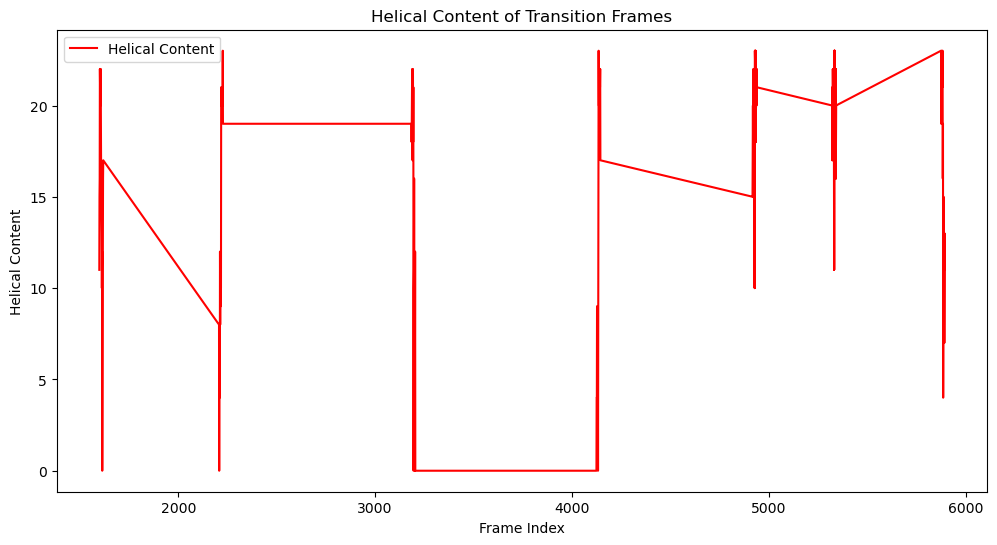

In [173]:
# Define the transition frames
transition_frames = []
window_size = 10  # Adjust the window size as needed
for transition_time in transitions:
    # Extract the appropriate value from the tuple
    transition_time_value = transition_time[0]  # Assuming the transition time is the first element of the tuple
    
    # Check if transition_time_value is already a float
    if isinstance(transition_time_value, (int, float)):
        transition_time_numeric = transition_time_value
    else:
        try:
            # Convert transition_time_value to a float
            transition_time_numeric = float(transition_time_value)
        except TypeError:
            # Handle the case where transition_time_value cannot be converted to a float
            print(f"Error: Transition time '{transition_time_value}' is not convertible to a float.")
            continue
    
    # Find the index of the transition time in the time array
    idx = np.where(np.isclose(time, transition_time_numeric))[0][0]
    
    # Add frames around the transition time (adjust the window size as needed)
    transition_frames.extend(range(max(0, idx - window_size), min(len(dssp_full), idx + window_size + 1)))

# Extract DSSP information for transition frames
dssp_transition = dssp_full[transition_frames]

# Isolate the population of helices from the full dssp
dsspS = np.copy(dssp_transition)
dsspS[dsspS != 'H'] = 0
dsspS[dsspS == 'H'] = 1
dsspS = dsspS.astype(int)

# Calculate the helical content for each frame
helical_content_transition = np.sum(dsspS, axis=1)

# Plot the helical content distribution
plt.figure(figsize=(12, 6))
plt.plot(transition_frames, helical_content_transition, c='r', label='Helical Content')
plt.xlabel('Frame Index')
plt.ylabel('Helical Content')
plt.title('Helical Content of Transition Frames')
plt.legend(loc="upper left")
plt.show()


In [ ]:
#Consider using a windowing function to smooth our vlaues of Q for Transition Path Calculations
